In [5]:
import pandas as pd 
from pandas_datareader import data
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import re
import hvplot.pandas  # noqa
%matplotlib inline 
%config InlineBackend.figure_format='retina'
# pd.options.plotting.backend='hvplot'
import yfinance as yf

In [6]:
class DynamicSMA: 
    pd.set_option('display.max_rows', None)
    def  __init__(self,name:str,date:str):
        
        #init var
        self.EMAij = [] 
        self.winrate = []
        self.avg_profit = [] 
        self.df_generated = [] 
        

        #      init state
        self.name = name
        self.df = yf.Ticker(name).history(interval='1d',start=date)
#         self.df = data.DataReader(name,data_source="yahoo",start = date)
#         display(self.df)
        
        
    def nan_to_num(self,ema,dfChange):
            for i in range (ema): 
                dfChange.iloc[i] = self.df['Close'][i]
                
                
                
    def generate(self):
        
        loading = 0 

        for i in range (1,101,1):
            if(i > 1*loading):
                loading+=1
                print(f"|{loading}/100|", end='\r')


            for j in range (i+1,101,1):
                df_EMAi = self.df['Close'].rolling(window=i).mean()
                df_EMAj = self.df['Close'].rolling(window=j).mean()
                crossup_time = 0
                win = 0 
                k=0
                cutting_point = 0 
                state = "none"
                loss_or_profit = []


                self.nan_to_num(i,df_EMAi)
                self.nan_to_num(j,df_EMAj)

                while(k<self.df.shape[0]):

                    if(df_EMAi.iloc[k] > df_EMAj.iloc[k] and state == "none"):
                        state = "cut"
                        crossup_time += 1
                        cutting_point = k 
                        k+=1


                    elif(state == "cut" and (df_EMAi.iloc[k] < df_EMAj.iloc[k]) ):
                        state = "none"
                        loss_or_profit.append((self.df['Close'][k]-self.df['Close'][cutting_point])/self.df['Close'][cutting_point])
                        if(self.df['Close'][cutting_point] < self.df['Close'][k]):
                            win += 1 

                    else: 
                        k+=1 

                if(len(loss_or_profit) == 0 ):
                    
                    self.avg_profit.append(0)
                    self.EMAij.append(f"{i} {j}")
                    self.winrate.append(0)
                    continue

                self.winrate.append((win/crossup_time)*100)
                self.avg_profit.append(sum(loss_or_profit)/len(loss_or_profit)*100)
                self.EMAij.append(f"{i} {j}")
        
        self.df_generated = pd.DataFrame({'EMA':self.EMAij,'WR':self.winrate,'AVGPF':self.avg_profit},columns= ['EMA','WR','AVGPF'] )
        self.df_generated.index.name = self.name
        
    
    def show_best_winrate(self):
        
        return self.df_generated.sort_values(by='WR',ascending=False,inplace=False)
        
    def show_worst_winrate(self):
        return self.df_generated.sort_values(by='WR',ascending=True,inplace=False)
        
    def show_best_to_worst_profit(self):
        return self.df_generated.sort_values(by='AVGPF',ascending=False,inplace=False)
    
    def show_describe(self):
        return self.df_generated.describe()
        
    def show_hist(self):
        return self.df_generated.hist()
        
    
        
    def init_graph(self,u1,u2,d1,d2): 
        
        df_EMAu1 = self.df['Close'].rolling(window=u1).mean()
        df_EMAu2 = self.df['Close'].rolling(window=u2).mean()
        df_EMAd1 = self.df['Close'].rolling(window=d1).mean()
        df_EMAd2 = self.df['Close'].rolling(window=d2).mean()
        
        
        
        self.nan_to_num(u1,df_EMAu1)
        self.nan_to_num(u2,df_EMAu2)
        self.nan_to_num(d1,df_EMAd1)
        self.nan_to_num(d2,df_EMAd2)
        
        df_all_data_plot = pd.DataFrame({f"EMAu1/{u1}":df_EMAu1,f"EMAu2/{u2}":df_EMAu2,f"EMAd1/{d1}":df_EMAd1
                                         ,f"EMAd2/{d2}":df_EMAd2})
        
        
        df_plot_up = pd.DataFrame({f'EMA{u1}':df_EMAu1,f'EMA{u2}':df_EMAu2})
        df_plot_down = pd.DataFrame({f'EMA{d1}':df_EMAd1,f'EMA{d2}':df_EMAd2})
        state = ["none","none"]
        cross_slot_up = []
        cross_slot_down = [] 
        k_up=0
        k_down=0
        
        while(k_up<self.df.shape[0]):
            
           
            if(df_EMAu1.iloc[k_up] > df_EMAu2.iloc[k_up] and state[0] == "none"):
                state[0] = "cut"
                cross_slot_up.append(self.df['Close'].iloc[k_up]) 
                           
            
            elif(state[0] == "cut" and (df_EMAu1.iloc[k_up] < df_EMAu2.iloc[k_up]) ):
                state[0] = "none"
                cross_slot_up.append(np.nan)
                         
            else: 
                cross_slot_up.append(np.nan)
                
            k_up+=1
            
            
            
        while(k_down<self.df.shape[0]):
            
           
            if(df_EMAd1.iloc[k_down] > df_EMAd2.iloc[k_down] and state[1] == "none"):
                state[1] = "cut"
                cross_slot_down.append(self.df['Close'].iloc[k_down]) 
                           
            
            elif(state[1] == "cut" and (df_EMAd1.iloc[k_down] < df_EMAd2.iloc[k_down]) ):
                state[1] = "none"
                cross_slot_down.append(np.nan)
                         
            else: 
                cross_slot_down.append(np.nan)
                
            k_down+=1
            
        
                
        
        
        df_cut = df_all_data_plot.assign(CutUp=cross_slot_up , CutDown=cross_slot_down)
        
        return df_cut

    def show_graph(self,ema_list):
        df_init_graph = self.init_graph(ema_list[0],ema_list[1],ema_list[2],ema_list[3])
        display(self.df['Close'].hvplot.step(width=900, height=600,title=self.name) *df_init_graph['CutDown'].hvplot.scatter(c='black')*df_init_graph['CutUp'].hvplot.scatter(c='r')*df_init_graph.hvplot(alpha=0.4))
       

In [24]:
stock = DynamicSMA("amata.bk","2021-01-01")

In [25]:
stock.generate()

In [26]:
stock.show_best_winrate()

,EMA,WR,AVGPF
amata.bk,,,
4265,63 82,87.500000,1.041380
4266,63 83,87.500000,1.659182
4267,63 84,87.500000,2.342419
4149,60 80,85.714286,1.369631
4120,59 91,85.714286,2.333727
4148,60 79,85.714286,1.248889
4074,58 86,85.714286,1.652282
4032,57 86,85.714286,2.003927
4105,59 76,85.714286,3.781844


In [27]:
stock.show_worst_winrate()

,EMA,WR,AVGPF
amata.bk,,,
3160,40 81,0.000000,-2.725086
3040,38 82,0.000000,-4.204504
3038,38 80,0.000000,-3.659491
2915,36 82,0.000000,-3.873159
2914,36 81,0.000000,-4.728541
2913,36 80,0.000000,-4.728541
3101,39 82,0.000000,-5.025523
2976,37 80,0.000000,-4.007921
2977,37 81,0.000000,-4.562706


In [28]:
stock.show_best_to_worst_profit()

,EMA,WR,AVGPF
amata.bk,,,
4017,57 71,66.666667,5.401920
4014,57 68,66.666667,5.367171
4015,57 69,66.666667,5.200609
4016,57 70,66.666667,5.085512
4058,58 70,66.666667,4.850946
4018,57 72,66.666667,4.481908
4057,58 69,66.666667,4.319693
4021,57 75,66.666667,4.183122
4020,57 74,66.666667,4.165216


In [29]:
stock.show_describe()


,WR,AVGPF
count,4950.000000,4950.000000
mean,44.851478,-0.430065
std,14.282506,1.294232
min,0.000000,-5.025523
25%,35.000000,-1.209014
50%,42.857143,-0.525564
75%,54.545455,0.266884
max,87.500000,5.401920


array([[<AxesSubplot:title={'center':'WR'}>,
        <AxesSubplot:title={'center':'AVGPF'}>]], dtype=object)

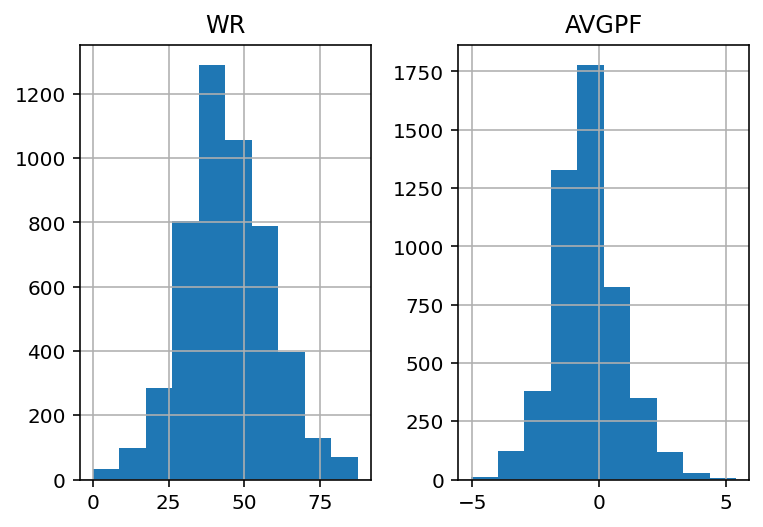

In [30]:
stock.show_hist()

In [31]:
stock.show_graph([63,84,0,0])

:Overlay
   .Curve.Close     :Curve   [Date]   (Close)
   .Scatter.CutDown :Scatter   [Date]   (CutDown)
   .Scatter.CutUp   :Scatter   [Date]   (CutUp)
   .NdOverlay.I     :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [16]:
stockList = {
    'aav':[9,28,37,88],
    'ah.bk':[48,54,47,89],
    'aot.bk':[24,80,0,0],
#     'advanc.bk' : [62,78,25,33],
#     'bla.bk' : [47,71,15,23],
#     'ckp.bk' : [68,80,23,42],
#     'com7.bk' : [17,24,27,68],
#     'crc.bk' : [8,28,35,60],
#     'drt.bk' : [33,62,56,80],
#     'dohome.bk' : [7,70,58,79], 
    'ea.bk' : [41,76,0,0],
#     'global.bk' : [50,64,35,79],
#     'gulf.bk' : [67,77],
#     'gunkul.bk' : [38,80],
#     'hana.bk' : [76,80],
#     'htc.bk' : [25,76],
#     'intuch.bk' : [23,43],
#     'sat.bk' : [18,52],
#     'ori.bk':[40,50],
#     'mint.bk':[54,78],
#     'tks.bk':[12,48],
#     'amata.bk':[57,69],
#     'banpu.bk':[6,67],
#     'top.bk':[13,24],
#     'synex.bk':[17,30],
#     'be8.bk':[7,33],
#     'bdms.bk':[20,72]
}

In [65]:
# for stock in stockList : 
#     DynamicSMA(stock,"2021-01-01").show_graph(stockList[stock])